## **Dogs vs Cats image classification**

### **1. Import libraries**

In [ ]:
import os
import tensorflow as tf
import shutil
import matplotlib.pyplot as plt
import numpy as np

### **2. Load the dataset**

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 796M/814M [00:11<00:00, 81.1MB/s]
100% 814M/814M [00:11<00:00, 73.7MB/s]


In [ ]:
!unzip -q dogs-vs-cats-redux-kernels-edition.zip -d.
!unzip -q train.zip -d.

In [ ]:
len(os.listdir('/content/train/'))

25000

In [ ]:
os.mkdir('/content/data/')
os.mkdir('/content/data/cats/')
os.mkdir('/content/data/dogs/')

In [ ]:
for i in os.listdir('/content/train/'):
  if 'cat' in i:
    shutil.copyfile('/content/train/'+i, '/content/data/cats/'+i )
  if 'dog' in i:
    shutil.copyfile('/content/train/'+i, '/content/data/dogs/'+i )

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data/',
    image_size=(64, 64),
    batch_size=64,
    subset='training',
    validation_split=0.2,
    seed=42
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data/',
    image_size=(64, 64),
    batch_size=64,
    subset='validation',
    validation_split=0.2,
    seed=42
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
print(train_ds, valid_ds, sep='\n')

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### **3. Explore the data**

In [ ]:
for i, target in train_ds.take(1):
  print(i[0])
  print(target[:10])

tf.Tensor(
[[[216.11719 216.11719 208.11719]
  [219.85156 219.85156 211.85156]
  [217.11035 217.11035 209.11035]
  ...
  [218.26465 219.26465 202.01465]
  [220.03223 221.03223 203.78223]
  [224.01562 225.01562 207.76562]]

 [[214.25    214.25    206.     ]
  [215.75293 215.75293 207.50293]
  [218.87012 218.87012 210.62012]
  ...
  [208.90918 209.90918 194.15918]
  [211.57324 212.57324 196.82324]
  [217.50879 218.50879 202.75879]]

 [[211.02344 211.02344 199.02344]
  [215.05469 215.05469 203.05469]
  [218.21094 218.21094 206.21094]
  ...
  [210.87988 210.87988 198.87988]
  [212.92188 212.92188 200.92188]
  [215.13965 215.13965 203.13965]]

 ...

 [[179.50781 185.53125 183.83594]
  [211.15625 212.15625 198.11523]
  [205.50293 204.50293 199.54199]
  ...
  [217.19336 215.19336 200.19336]
  [194.01074 192.01074 177.01074]
  [211.49219 209.49219 194.49219]]

 [[194.19043 199.21387 205.01855]
  [190.95508 190.95508 180.66406]
  [199.5     199.34082 191.85742]
  ...
  [210.68066 208.68066 193.

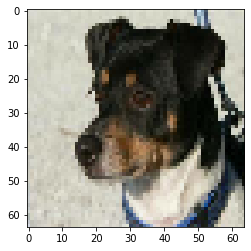

In [ ]:
plt.imshow(i[0].numpy().astype('uint8'))
plt.show()

### **4. Preprocess the data**

In [ ]:
def preprocessing(i, target):
  i = tf.cast(i/255.0, tf.float32)
  return i, target

train_ds = train_ds.map(preprocessing)
valid_ds = valid_ds.map(preprocessing)

In [ ]:
for i, target in train_ds.take(1):
  print(i[0])
  print(target[:10])

tf.Tensor(
[[[0.93602747 0.9752432  0.97720015]
  [0.9566234  0.997415   0.9736462 ]
  [0.97331685 0.9967946  0.98914486]
  ...
  [0.6900927  0.744627   0.7448721 ]
  [0.6284639  0.65763056 0.68201786]
  [0.23094745 0.23646216 0.21685432]]

 [[0.43974036 0.46443972 0.44524357]
  [0.59622586 0.6275984  0.58446115]
  [0.7544826  0.7819336  0.7505936 ]
  ...
  [0.6332874  0.6801011  0.6803462 ]
  [0.49942362 0.51204616 0.54121286]
  [0.2178711  0.20696422 0.19360639]]

 [[0.97267157 0.97735715 0.9958525 ]
  [0.9739296  0.9824429  0.97919154]
  [0.9666494  0.98922527 0.9895929 ]
  ...
  [0.5387408  0.5779833  0.5820006 ]
  [0.50803846 0.51061195 0.5428424 ]
  [0.22702205 0.20119295 0.19150199]]

 ...

 [[0.8576919  0.83808404 0.6114909 ]
  [0.88933825 0.86580884 0.67058825]
  [0.914141   0.8906116  0.7023763 ]
  ...
  [0.13210018 0.10035999 0.09251685]
  [0.11597159 0.09636374 0.08459903]
  [0.13668045 0.09599418 0.0928079 ]]

 [[0.85043466 0.84142154 0.6584176 ]
  [0.9246764  0.9129117  0

### **5. Build the model+Data augmentation/Dropout**

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal', input_shape=(64, 64, 3)),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'), 
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'), 
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'), 
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1 , activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1

### **6. Compile the model**

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### **7. Train the model+callback**

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint/save',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [ ]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=20, callbacks=[model_checkpoint_callback])

Epoch 1/20
313/313 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.5843
Epoch 1: val_accuracy improved from -inf to 0.63080, saving model to model_checkpoint/save
313/313 [==============================] - 34s 68ms/step - loss: 0.6688 - accuracy: 0.5843 - val_loss: 0.6238 - val_accuracy: 0.6308
Epoch 2/20
308/313 [============================>.] - ETA: 0s - loss: 0.6054 - accuracy: 0.6709
Epoch 2: val_accuracy improved from 0.63080 to 0.65860, saving model to model_checkpoint/save
313/313 [==============================] - 22s 68ms/step - loss: 0.6047 - accuracy: 0.6715 - val_loss: 0.6143 - val_accuracy: 0.6586
Epoch 3/20
311/313 [============================>.] - ETA: 0s - loss: 0.5647 - accuracy: 0.7057
Epoch 3: val_accuracy improved from 0.65860 to 0.71580, saving model to model_checkpoint/save
313/313 [==============================] - 21s 67ms/step - loss: 0.5645 - accuracy: 0.7060 - val_loss: 0.5429 - val_accuracy: 0.7158
Epoch 4/20
312/313 [==============

### **8. Evaluate the model**

79/79 - 4s - loss: 0.3582 - accuracy: 0.8352 - 4s/epoch - 50ms/step


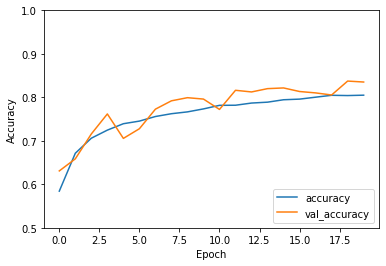

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(valid_ds, verbose=2)

### **9. Load the previously saved weights**

In [ ]:
model_cp = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal', input_shape=(64, 64, 3)),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'), 
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'), 
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'), 
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1 , activation='sigmoid'),
])

In [ ]:
model_cp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_cp.load_weights('model_checkpoint/save')
test_loss, test_acc = model_cp.evaluate(valid_ds, verbose=2)

79/79 - 4s - loss: 0.3582 - accuracy: 0.8374 - 4s/epoch - 52ms/step


In [ ]:
print('Test accuracy :', np.round(test_acc * 100, 4))

Test accuracy : 83.74
